In [9]:
# Import the dependencies
import numpy as np
from scipy.linalg import toeplitz, cholesky, sqrtm, inv
# import scipy.linalg as la
from scipy import signal
from scipy.integrate import odeint
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
print("Imports done")
from statistics import mean, variance, pstdev


Imports done


In [10]:
# Setting up the time data:
dt = 0.005; # integration step, average neuron resets 200 times per second
T = 50 + dt; # maximum time considered
t = np.arange(0,T,dt)
N= t.size #Amount of data points

In [11]:
def temporalC(p,s2):

    q = np.arange(p+1)
   
    r = np.zeros(1+2*(p))
   
    r[2*q] = np.cumprod(1-2*q)/(2*s2)**(q)   
    
    
    S = np.empty([0,p+1])
   

    for i in range(p+1):
        S = np.vstack([S,r[q+i]])
        r = -r
   
    return S 

In [12]:
def makeNoise(C,s2,t):
 
    if np.size(C)== 1:
        n = 1
    else:
        n = C.shape[1]  # dimension of noise
        
    # Create the white noise with correct covariance
    N = np.size(t)      # number of elements
   
    L =cholesky(C, lower=True)  #Cholesky method
    
    w = np.dot(L,np.random.randn(n,N))
    
    print(w)
    
    if s2 <= 1e-5: # return white noise
        return w
    else: 
        # Create the noise with temporal smoothness
        P = toeplitz(np.exp(-t**2/(2*s2)))
        print(P)
        F = np.diag(1./np.sqrt(np.diag(np.dot(P.T,P))))
     
        K = np.dot(P,F)

        ws = np.dot(w,K)
     
        return ws

In [13]:
#initate arrays
mu_x = np.zeros(N)
e_x = np.zeros(N)
e_y = np.zeros(N)
y =np.zeros(N)
x = np.zeros(N)
dfmu_x= np.zeros(N)
u = np.zeros(N)

omega_w0 = np.zeros(N)
omega_w1 = np.zeros(N)
omega_z0 = np.zeros(N)
omega_z1 = np.zeros(N)

sigma_w0 = np.zeros(N)
sigma_w1= np.zeros(N)
sigma_z0 = np.zeros(N)
sigma_z1= np.zeros(N)
std = np.zeros(N)

omega_w0[0] = 1
omega_w1[0] = 1
omega_z0[0] = 1
omega_z1[0] = 1

mu_v = np.ones(N)*25
mu_x[0]= 25
x[0] = 30
u[0] = 0

# #noise standard deviations and gain
# std_noise_x = 0.1
# std_noise_y = 1
# std_noise_ydot = 0.1

#learning rates
# alpha_x = [1,0.1]
# alpha_y = [0.1,0.1]

alpha_x = 0.1
alpha_y = 0.1
alpha_mux = 10
alpha_u = 10


# #noise standard deviations and gain
# std_noise_x = 0.5
# std_noise_y = 1
# std_noise_ydot = 0.1

# #learning rates
# alpha_x = [1,1]
# alpha_y = [0.1,0.5]
# alpha_mux = 10
# alpha_u = 10



In [14]:
#create D matrix
def derivativeD(p):
    
    D = toeplitz(np.zeros([1,p+1]),np.append(np.array([0,1]),np.zeros([1,p-1])))
           
    return D


D = derivativeD(1)

In [15]:
#GM and GP

#Generative process functions
def f_gp(x, u):
    #a = -1
    a = 0 
    b = 1
  
    return a*x + b*u 
def df_gp(x, u):
    a = -1
    #a = 0
    return a



def g_gp(x):

    t0=25
    return t0 -16 / (1 + np.exp(5-x/5))

def dg_gp(x):
    
    return -16/5* np.exp(5-x/5) / (np.exp(5-x/5)+1)**2



#generative model functions
def f_gm(mu_x, mu_v):
    
    a = -1 
    b = 1
    return a*mu_x +b*mu_v


def df_gm(mu_x, mu_v):
    
    a = -1
    return a


def g_gm(mu_x,mu_v):

    t0=25
    return t0 -16 / (1 + np.exp(5-mu_x/5))

def dg_gm(mu_x,mu_v):
    
    return -16/5* np.exp(5-mu_x/5) / (np.exp(5-mu_x/5)+1)**2


In [16]:
#initiate mu_x_tilde, Atilde and I
y_tilde = np.zeros((N,2,1))
mu_x_tilde = np.zeros((N,2,1))

#mu_x_tilde[0] = [[mu_x[0]],[0]] #depending on what model you want to start with
mu_x_tilde[0] = [[mu_x[0]],[f_gm(mu_x[0], mu_v[0])]]



Atilde = np.identity(2)*(-1)
I = np.identity(2)


In [17]:
eps_x0_list = []
eps_x1_list = []

eps_y0_list = []
eps_y1_list = []

In [18]:

                # C, s2,      t
noise = makeNoise(0.1, 0.000001, t)

[[-0.0329613  -0.50298452  0.03618854 ...  0.23814891 -0.00518335
   0.60119643]]


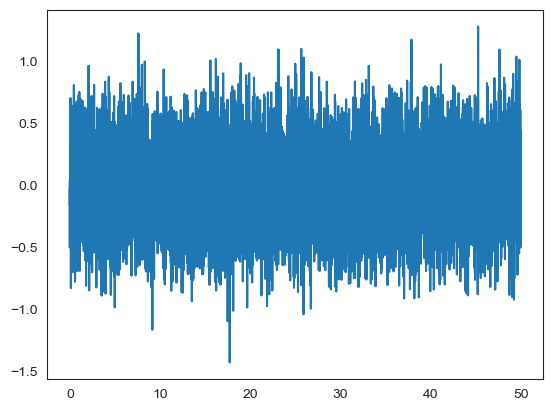

In [19]:
plt.figure()
plt.plot(t,noise[0])

In [20]:
for i in np.arange(0,N-1):
    
    #generative process
    x_dot = f_gp(x[i],u[i])             + noise[0,i]
    x[i+1] = x[i] + dt*x_dot
    
    y = g_gp(x[i])                      + noise[0,i]
    ydot = dg_gp(x[i])*f_gp(x[i],u[i])  
    y_tilde[i] = [[y],[ydot]]

    

    # Generative model
    PI_w = np.diag([omega_w0[i],omega_w1[i]])
    PI_z = np.diag([omega_z0[i],omega_z1[i]])
                             
    mu_x_hat = np.array([[1],[0]]) * f_gm(mu_x[i],mu_v[i]) +  np.array([[0],[1]])*df_gm(mu_x[i],mu_v[i])*(mu_x_tilde[i])
    mu_y_hat = np.array([[1],[0]]) * g_gm(mu_x[i],mu_v[i]) +  np.array([[0],[1]])*dg_gm(mu_x[i],mu_v[i])*(mu_x_tilde[i])
   
    #prediction error and producing lists for plotting
    eps_x = D.dot(mu_x_tilde[i])-mu_x_hat 
    eps_y = y_tilde[i] - mu_y_hat  
    
    eps_x0_list.append(eps_x[0,0])
    eps_x1_list.append(eps_x[1,0])
    eps_y0_list.append(eps_y[0,0])
    eps_y1_list.append(eps_y[1,0])
    
    #  optimization hidden state
    dFdmu_x = (D-Atilde).T.dot(PI_w).dot(eps_x) - (dg_gm(mu_x[i],mu_v[i]) * I ).T.dot(PI_z).dot(eps_y)
    dmu_x = np.dot(D,mu_x_tilde[i]) - alpha_mux*dFdmu_x #evt alpha toevoegen
    mu_x_tilde[i+1] = mu_x_tilde[i]+ dt*dmu_x
    mu_x[i+1] = mu_x_tilde[i+1,0] #use this for plotting
    dfmu_x[i+1] = mu_x_tilde[i+1,1]

    #optimizing action
    u_dot = -np.array([0,dg_gp(x[i])]).dot(PI_z).dot(eps_y) #dy du simplified because b = 1
    u[i+1] = u[i] + alpha_u*dt*u_dot




    domega_w0 = 0.5*(alpha_x*(1/omega_w0[i]- eps_x[0]**2))
    domega_z0 = 0.5*(alpha_y*(1/omega_z0[i]- eps_y[0]**2))
    
    omega_w0[i+1] = omega_w0[i] + dt*domega_w0
    omega_z0[i+1] = omega_z0[i] + dt*domega_z0

                   #p, s2
    S_w = temporalC(1,0.01)
    S_z = temporalC(1,0.01)

    PI_w = inv(S_w)*omega_w0[i+1]
    PI_z = inv(S_z)*omega_z0[i+1]


    omega_w0[i+1] = PI_w[0,0]
    omega_w1[i+1] = PI_w[1,1]
    omega_z0[i+1] = PI_z[0,0]
    omega_z1[i+1] = PI_z[1,1]
    
    sigma_w0[i+1] = 1/omega_w0[i+1]
    sigma_w1[i+1] = 1/omega_w1[i+1]
    sigma_z0[i+1] = 1/omega_z0[i+1] 
    sigma_z1[i+1] = 1/omega_z1[i+1]


  

[-3.729898563006092, -4.080470193565265, -3.4156257129852, -3.515627107423791, -3.290307411279347, -3.253233276642968, -2.7873103622844155, -3.467513757759731, -2.964966269277868, -3.036945255034567, -2.8450200608779266, -3.2249739207354846, -2.835894711810413, -2.4133244638920957, -2.5921721567863987, -2.3514345375028167, -1.8660040290972315, -2.7266152984374976, -2.432147358696616, -2.563647846551751, -2.8574795272885076, -2.2040000527478742, -2.2626287058872148, -2.6346355881132304, -2.1821853799440785, -3.1050334023821478, -2.191982691632729, -2.1548150020287853, -2.0827325637759984, -1.8629408949857833, -2.228110072487965, -2.3515429316101084, -1.6461832963133691, -2.0064194530820245, -2.1606219306888086, -2.5319295771982837, -1.9490811496384133, -1.6942510586425037, -2.0071069693460597, -1.5278983287622214, -1.9634520337472168, -1.296045627958227, -1.705934228357929, -1.6153546531853369, -1.5790867519990215, -1.9333024777921608, -1.8079837245472437, -1.3796485920637078, -1.873310

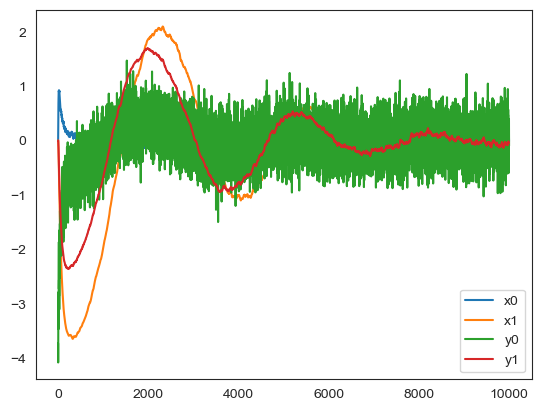

In [21]:
plt.figure()
plt.plot(eps_x0_list, label = "x0")
plt.plot(eps_x1_list, label = "x1")
plt.plot(eps_y0_list, label = "y0")
plt.plot(eps_y1_list,  label = "y1")
plt.legend()
# plt.plot(eps_x1_list)

print(eps_y0_list)

In [22]:
# print(np.var(eps_x0_list[200000:]), "eps_x0")
# print(np.mean(sigma_w0[200000:]), "sigma_w0")

# print(np.var(eps_x1_list[200000:]), "eps_x1")
# print(np.mean(sigma_w1[200000:]), "sigma_w1")

# print(np.var(eps_y0_list[200000:]), "eps_y0")
# print(np.mean(sigma_z0[200000:]), "sigma_z0")

# print(np.var(eps_y1_list[200000:]), "eps_y1")
# print(np.mean(sigma_z1[200000:]), "sigma_z1")

print(np.var(eps_x0_list[199000:]), "eps_x0")
print(sigma_w1[-1], "sigma_w0")

print(np.var(eps_x1_list), "eps_x1")
print(np.mean(sigma_w1[-1]), "sigma_w1")

print(np.var(eps_y0_list), "eps_y0")
print(np.mean(sigma_z0[-1]), "sigma_z0")

print(np.var(eps_y1_list), "eps_y1")
print(np.mean(sigma_z1[-1]), "sigma_z1")

nan eps_x0
20.485502904772847 sigma_w0
1.4654938671366649 eps_x1
20.485502904772847 sigma_w1
0.18836830198796786 eps_y0
0.4598573990181632 sigma_z0
0.6764873563069195 eps_y1
22.99286995090816 sigma_z1


c:\Users\SIDTUDelft\anaconda3\envs\Affective-AI\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\SIDTUDelft\anaconda3\envs\Affective-AI\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\SIDTUDelft\anaconda3\envs\Affective-AI\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


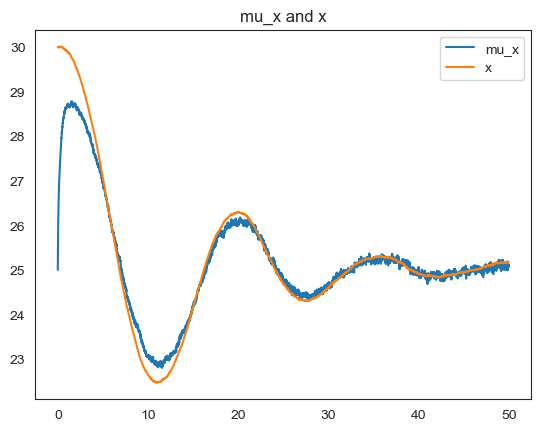

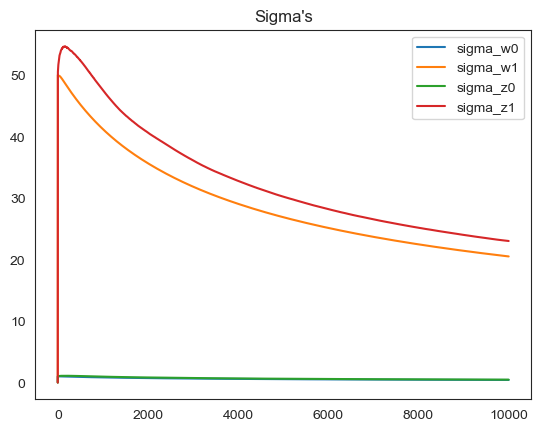

In [23]:
plt.figure()
plt.plot(t,mu_x, label = "mu_x")
plt.plot(t,x, label = "x")
plt.title(label = "mu_x and x")

plt.legend()

plt.figure()
plt.plot(sigma_w0, label = "sigma_w0")
plt.plot(sigma_w1, label = "sigma_w1")
plt.plot(sigma_z0, label = "sigma_z0")
plt.plot(sigma_z1, label = "sigma_z1")
plt.title(label = "Sigma's")
plt.legend()

